In [9]:
###### import commands
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import precision_recall_curve, roc_curve, auc
from sklearn.utils import resample

In [10]:
#### read model
df=pd.read_csv('train.csv', encoding = 'ISO-8859-1', low_memory=False)
df=df.set_index('ticket_id')

# drop bad columns
df=df.dropna(axis='columns',thresh=len(df)*1/4)

dfOG=df.copy()

In [11]:
#### create new feature - time difference between ticket and hearing dates
tdiff=pd.to_datetime(dfOG['hearing_date'])-pd.to_datetime(dfOG['ticket_issued_date'])
dfOG['TimeDiff']=tdiff.dt.total_seconds()/86400

In [12]:
#### add month feature for issue and hearing date, also day and weekday
dfOG['hearing_month']=pd.to_datetime(dfOG['hearing_date']).dt.month
dfOG['issue_month']=pd.to_datetime(dfOG['ticket_issued_date']).dt.month

dfOG['hearing_day']=pd.to_datetime(dfOG['hearing_date']).dt.day
dfOG['issue_day']=pd.to_datetime(dfOG['ticket_issued_date']).dt.day

dfOG['hearing_dayofweek']=pd.to_datetime(dfOG['hearing_date']).dt.weekday
dfOG['issue_dayofweek']=pd.to_datetime(dfOG['ticket_issued_date']).dt.weekday


In [13]:
#### read latlon, addresses
latlon_df=pd.read_csv('latlons.csv')
add_df=pd.read_csv('addresses.csv')
add_df['address'] = add_df['address'].str.upper()

In [14]:
#### merge latlon, addresses on addresses column

# latlon_df['address']
latlon_df['address'] = latlon_df['address'].str.upper()
latlon_df.head()

df_info=add_df.merge(latlon_df,left_on='address',right_on='address')
df_info=df_info.set_index('ticket_id')
print('add={:d} + ll={:d} = {:d}'.format(len(add_df),len(latlon_df),len(df_info)))

# there should be 8 rows with nan lat/lon
# df_info['lon'].isna().sum() # =8
# df_info.head()


add=311307 + ll=121769 = 311307


In [15]:
#### merge latlon info into main df
df2=dfOG.merge(df_info,left_index=True,right_index=True, how='left')
print('og={:d} + info={:d} = {:d}'.format(len(dfOG),len(df_info),len(df2)))
dfOG=df2.copy()
df=df2.copy()

og=250306 + info=311307 = 250306


In [16]:
## what types of data are in here? the 'compliance' column is the target value (0 or 1)
y=df['compliance']
X=df.drop(['compliance'],axis=1)
X.iloc[0]

agency_name                      Buildings, Safety Engineering & Env Department
inspector_name                                                  Sims, Martinzie
violator_name                                 INVESTMENT INC., MIDWEST MORTGAGE
violation_street_number                                                    2900
violation_street_name                                                     TYLER
mailing_address_str_number                                                    3
mailing_address_str_name                                              S. WICKER
city                                                                    CHICAGO
state                                                                        IL
zip_code                                                                  60606
country                                                                     USA
ticket_issued_date                                          2004-03-16 11:40:00
hearing_date                            

In [17]:
## what is the cardinality of each column?
for col in X.columns:
    print('{} - {}'.format(col,len(X[col].value_counts())))
    

agency_name - 5
inspector_name - 173
violator_name - 119992
violation_street_number - 19175
violation_street_name - 1791
mailing_address_str_number - 15826
mailing_address_str_name - 37896
city - 5184
state - 59
zip_code - 4251
country - 5
ticket_issued_date - 86979
hearing_date - 6222
violation_code - 235
violation_description - 258
disposition - 9
fine_amount - 43
admin_fee - 2
state_fee - 2
late_fee - 37
discount_amount - 13
clean_up_cost - 1
judgment_amount - 57
payment_amount - 533
balance_due - 606
payment_status - 3
compliance_detail - 10
TimeDiff - 33217
hearing_month - 12
issue_month - 12
hearing_day - 31
issue_day - 31
hearing_dayofweek - 6
issue_dayofweek - 7
address - 95598
lat - 78694
lon - 87249


In [45]:
# good ones - ['discount_amount', 'disposition', ]

for var in X.columns:
#     var='agency_name'


    ctTot=pd.crosstab(X[var], y, margins=True)
    ctNorm=pd.crosstab(X[var], y, normalize='index', margins=True)
#     ctNorm
    # X.issue_day.value_counts()
    ctNorm['N']=X[(y==1) | (y==0)][var].value_counts() # not great, should merge on keys instead assuming everything lines up
    ctNorm['Nall']=X[var].value_counts()
    print(ctNorm.sort_values(by=['N'], ascending=False))
# ctNorm

compliance                                           0.0       1.0        N  \
agency_name                                                                   
Buildings, Safety Engineering & Env Department  0.939257  0.060743  95863.0   
Department of Public Works                      0.910039  0.089961  52445.0   
Health Department                               0.934149  0.065851   7107.0   
Detroit Police Department                       0.868280  0.131720   4464.0   
Neighborhood City Halls                         1.000000  0.000000      1.0   
All                                             0.927464  0.072536      NaN   

compliance                                          Nall  
agency_name                                               
Buildings, Safety Engineering & Env Department  157784.0  
Department of Public Works                       74717.0  
Health Department                                 8903.0  
Detroit Police Department                         8900.0  
Neighborhood 

compliance                    0.0       1.0      N   Nall
violation_street_number                                  
19300.0                  0.932039  0.067961  103.0  153.0
15700.0                  0.917647  0.082353   85.0  123.0
600.0                    0.891566  0.108434   83.0  182.0
2900.0                   0.855263  0.144737   76.0   99.0
6300.0                   0.918919  0.081081   74.0  102.0
20400.0                  0.958904  0.041096   73.0   99.0
7400.0                   0.930556  0.069444   72.0   95.0
18400.0                  0.915493  0.084507   71.0  106.0
18500.0                  0.887324  0.112676   71.0  102.0
8200.0                   0.915493  0.084507   71.0  115.0
14800.0                  0.970588  0.029412   68.0   99.0
8100.0                   0.882353  0.117647   68.0  104.0
4800.0                   0.852941  0.147059   68.0   79.0
3737.0                   0.985075  0.014925   67.0   79.0
20200.0                  0.938462  0.061538   65.0  112.0
20500.0       

compliance                     0.0       1.0       N    Nall
mailing_address_str_name                                    
PO BOX                    0.969760  0.030240  5754.0  8668.0
P.O. BOX                  0.963871  0.036129  4733.0  7182.0
GRAND RIVER               0.926966  0.073034   890.0  1249.0
LIVERNOIS                 0.931242  0.068758   829.0  1205.0
W. MCNICHOLS              0.902475  0.097525   687.0   990.0
HARPER                    0.909427  0.090573   541.0   713.0
GREENFIELD                0.935167  0.064833   509.0   762.0
W. SEVEN MILE             0.933735  0.066265   498.0   673.0
GRATIOT                   0.879518  0.120482   498.0   757.0
P.O. Box                  0.945122  0.054878   492.0   707.0
P. O. BOX                 0.980687  0.019313   466.0   653.0
MACK                      0.937093  0.062907   461.0   641.0
WOODWARD                  0.847534  0.152466   446.0   703.0
WYOMING                   0.906323  0.093677   427.0   647.0
E. JEFFERSON            

compliance       0.0       1.0       N     Nall
zip_code                                       
48227       0.936441  0.063559  7316.0  11617.0
48221       0.926106  0.073894  7213.0  11104.0
48235       0.935253  0.064747  6842.0  10796.0
48228       0.931796  0.068204  6026.0   9200.0
48219       0.934128  0.065872  5875.0   9170.0
48238       0.934867  0.065133  5435.0   8415.0
48224       0.942262  0.057738  5421.0   8372.0
48205       0.943955  0.056045  4764.0   7325.0
48204       0.924948  0.075052  4357.0   6919.0
48234       0.912250  0.087750  4057.0   6596.0
48213       0.942496  0.057504  3565.0   5462.0
48206       0.940109  0.059891  3473.0   5566.0
48223       0.933935  0.066065  3436.0   5428.0
48209       0.877960  0.122040  3294.0   5339.0
48075       0.939230  0.060770  3143.0   5064.0
48203       0.932312  0.067688  3132.0   5126.0
48210       0.917870  0.082130  3117.0   4987.0
48202       0.935769  0.064231  2600.0   4187.0
48207       0.907176  0.092824  2564.0  

compliance                 0.0       1.0        N     Nall
violation_code                                            
9-1-36(a)             0.925994  0.074006  64414.0  99091.0
9-1-81(a)             0.967941  0.032059  23145.0  43471.0
22-2-88               0.929114  0.070886  19073.0  28720.0
9-1-104               0.917765  0.082235  16927.0  22536.0
22-2-88(b)            0.936872  0.063128   4879.0   7238.0
22-2-45               0.868095  0.131905   4200.0   5394.0
9-1-105               0.911301  0.088699   3619.0   5072.0
9-1-110(a)            0.877026  0.122974   3147.0   4814.0
9-1-43(a) - (Dwellin  0.980940  0.019060   3043.0   5332.0
9-1-103(C)            0.853843  0.146157   2641.0   3537.0
22-2-22               0.899694  0.100306   2612.0   3755.0
22-2-43               0.867575  0.132425   2054.0   2903.0
19450901              0.972222  0.027778   1620.0   2963.0
22-2-17               0.929279  0.070721   1414.0   1940.0
22-2-61               0.752125  0.247875    706.0   1456

compliance                               0.0       1.0         N      Nall
disposition                                                               
Responsible by Default              0.961797  0.038203  138340.0  138340.0
Responsible by Admission            0.724984  0.275016   13701.0   13701.0
Responsible by Determination        0.692700  0.307300    7644.0    7644.0
Responsible (Fine Waived) by Deter  0.000000  1.000000     195.0     195.0
All                                 0.927464  0.072536       NaN       NaN
compliance        0.0       1.0        N      Nall
fine_amount                                       
250.0        0.936899  0.063101  86798.0  141245.0
50.0         0.909380  0.090620  20415.0   28378.0
100.0        0.882877  0.117123  15488.0   21435.0
200.0        0.900000  0.100000  12710.0   18683.0
500.0        0.945938  0.054062   6918.0   11244.0
1000.0       0.962538  0.037462   4965.0    7934.0
3500.0       0.979269  0.020731   3859.0    6269.0
300.0        0.9

compliance           0.0       1.0         N      Nall
payment_amount                                        
0.0             0.998470  0.001530  120269.0  209193.0
305.0           0.861877  0.138123    7544.0    7797.0
280.0           0.351388  0.648612    5908.0    6415.0
255.0           0.894000  0.106000    4500.0    4535.0
85.0            0.770547  0.229453    2689.0    2728.0
140.0           0.808858  0.191142    2145.0    2176.0
130.0           0.374054  0.625946    1981.0    2056.0
250.0           0.794714  0.205286    1627.0    1699.0
80.0            0.348635  0.651365    1612.0    1635.0
120.0           0.939627  0.060373    1557.0    1585.0
75.0            0.929813  0.070187    1553.0    1564.0
230.0           0.343393  0.656607    1226.0    1263.0
210.0           0.878247  0.121753     616.0     619.0
580.0           0.842209  0.157791     507.0     543.0
100.0           0.838407  0.161593     427.0     454.0
1130.0          0.897756  0.102244     401.0     438.0
50.0      

compliance               0.0       1.0      N   Nall
TimeDiff                                            
27.104166666666668  0.861878  0.138122  181.0  257.0
19.979166666666668  0.938547  0.061453  179.0  258.0
20.0                0.914634  0.085366  164.0  215.0
20.083333333333332  0.907407  0.092593  162.0  218.0
27.0                0.924051  0.075949  158.0  199.0
34.25               0.967742  0.032258  155.0  255.0
37.0                0.940000  0.060000  150.0  224.0
34.0                0.952381  0.047619  147.0  194.0
27.25               0.916084  0.083916  143.0  200.0
19.895833333333332  0.931298  0.068702  131.0  174.0
41.104166666666664  0.954198  0.045802  131.0  251.0
52.0                0.968992  0.031008  129.0  209.0
22.979166666666668  0.920635  0.079365  126.0  173.0
33.104166666666664  0.919355  0.080645  124.0  189.0
26.958333333333332  0.926829  0.073171  123.0  172.0
20.25               0.975610  0.024390  123.0  153.0
19.083333333333332  0.877049  0.122951  122.0 

compliance            0.0       1.0        N     Nall
issue_dayofweek                                      
1                0.926672  0.073328  36848.0  57477.0
2                0.926814  0.073186  34624.0  54235.0
3                0.926482  0.073518  32686.0  51090.0
0                0.931591  0.068409  28812.0  45071.0
4                0.927722  0.072278  26066.0  40813.0
5                0.880000  0.120000    525.0   1003.0
6                0.874608  0.125392    319.0    617.0
All              0.927464  0.072536      NaN      NaN
compliance                             0.0       1.0     N   Nall
address                                                          
600 WOODWARD AVE, DETROIT MI      1.000000  0.000000  52.0  127.0
16189 SCHAEFER, DETROIT MI        0.980000  0.020000  50.0   83.0
4471 PARKINSON, DETROIT MI        1.000000  0.000000  42.0   52.0
935 LOUISIANA, DETROIT MI         0.971429  0.028571  35.0   37.0
3900 OUTER DRIVE, DETROIT MI      1.000000  0.000000  33.0   42.

In [43]:
# ctTot=pd.crosstab(X['violation_zip_code'], y, margins=True)
# len(X['grafitti_status'].value_counts())
var='late_fee'
ctTot=pd.crosstab(X[var], y, margins=True)
ctNorm=pd.crosstab(X[var], y, normalize='index', margins=True)
#     ctNorm
# X.issue_day.value_counts()
ctNorm['N']=X[var].value_counts()
ctTot

compliance     0.0    1.0     All
late_fee                         
0.0           9856   5602   15458
0.1              0      1       1
2.5           1191     32    1223
5.0          16642   1013   17655
9.5              2      0       2
10.0         11645    871   12516
12.5           701     22     723
15.0             1      0       1
16.0             2      0       2
17.0             1      0       1
20.0         10665    689   11354
22.0             3      0       3
25.0         76742   2879   79621
30.0          3614     66    3680
35.0           121      5     126
40.0            35      1      36
45.0             1      0       1
50.0          6341    204    6545
60.0            10      0      10
65.5             1      0       1
67.7             1      0       1
75.0           209      8     217
97.0             0      1       1
100.0         4690    113    4803
120.0           40      0      40
125.0            2      0       2
150.0          243      8     251
175.0            0      2       2
200.0           14      0      14
250.0         1477     29    1506
269.5            0      1       1
300.0            4      0       4
350.0         3736     49    3785
500.0           85      0      85
700.0           13      0      13
800.0            1      0       1
1000.0         194      1     195
All         148283  11597  159880

250306

In [35]:
## Get ready to plot bar graphs comparing compliant and non-compliant groups for different columns
# first split into compliant and non-compliant (this leaves out ~90k that are null - not responsible)
Xall=X.loc[(y==1) | (y==0)] # not null
yall=y[(y==1) | (y==0)]
X1=X.loc[y==1]
X0=X.loc[y==0]
y1=y[y==1]
y0=y[y==0]
# X0=X.loc[y==0] # non-compliant

print("Compliant: {}, non-compliant: {}, all: {}".format(len(X1),len(X0),len(Xall)))

# define column name
var='late_fee'

# what are the unique values of this column
# vals=Xall[var].unique()
v1=X1[var].value_counts()
v0=X0[var].value_counts()

vcomb=pd.DataFrame(dict(noncomp=v0,comp=v1))
vcomb=vcomb.fillna(0)

vals=vcomb.index
vcomb


Compliant: 11597, non-compliant: 148283, all: 159880


noncomp    comp
0.0      9856.0  5602.0
0.1         0.0     1.0
2.5      1191.0    32.0
5.0     16642.0  1013.0
9.5         2.0     0.0
10.0    11645.0   871.0
12.5      701.0    22.0
15.0        1.0     0.0
16.0        2.0     0.0
17.0        1.0     0.0
20.0    10665.0   689.0
22.0        3.0     0.0
25.0    76742.0  2879.0
30.0     3614.0    66.0
35.0      121.0     5.0
40.0       35.0     1.0
45.0        1.0     0.0
50.0     6341.0   204.0
60.0       10.0     0.0
65.5        1.0     0.0
67.7        1.0     0.0
75.0      209.0     8.0
97.0        0.0     1.0
100.0    4690.0   113.0
120.0      40.0     0.0
125.0       2.0     0.0
150.0     243.0     8.0
175.0       0.0     2.0
200.0      14.0     0.0
250.0    1477.0    29.0
269.5       0.0     1.0
300.0       4.0     0.0
350.0    3736.0    49.0
500.0      85.0     0.0
700.0      13.0     0.0
800.0       1.0     0.0
1000.0    194.0     1.0

<IPython.core.display.Javascript object>


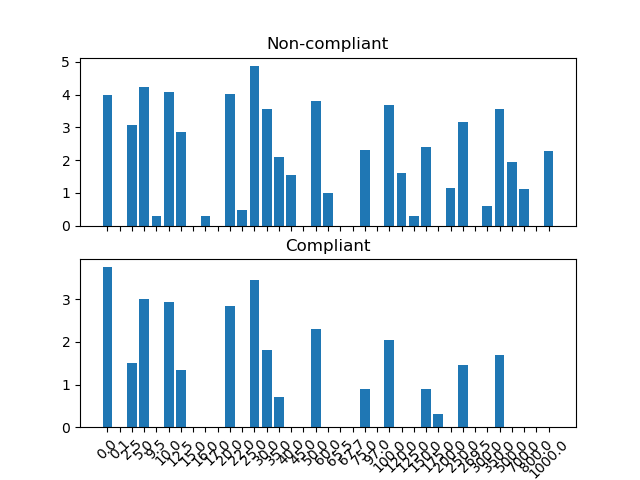

/Users/ulberg/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: RuntimeWarning: divide by zero encountered in log10
/Users/ulberg/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:23: RuntimeWarning: divide by zero encountered in log10


Float64Index([   0.0,    0.1,    2.5,    5.0,    9.5,   10.0,   12.5,   15.0,
                16.0,   17.0,   20.0,   22.0,   25.0,   30.0,   35.0,   40.0,
                45.0,   50.0,   60.0,   65.5,   67.7,   75.0,   97.0,  100.0,
               120.0,  125.0,  150.0,  175.0,  200.0,  250.0,  269.5,  300.0,
               350.0,  500.0,  700.0,  800.0, 1000.0],
             dtype='float64')

In [36]:
# bar plot comparing two sets
%matplotlib notebook
import matplotlib as mpl
import matplotlib.pyplot as plt

xpos=np.arange(len(vals))

# scaled by max value
# fig, (ax1, ax2) = plt.subplots(2,1,sharex=True,sharey=True)

# ax1.bar(xpos,(vcomb['noncomp']/np.max(vcomb['noncomp'])))
# ax1.set_title('Non-compliant')

# ax2.bar(xpos,(vcomb['comp']/np.max(vcomb['comp'])))
# ax2.set_title('Compliant')

# log10 of values, not very accurate for comparison
fig, (ax1, ax2) = plt.subplots(2,1,sharex=True)

ax1.bar(xpos,np.log10(vcomb['noncomp']))
ax1.set_title('Non-compliant')

ax2.bar(xpos,np.log10(vcomb['comp']))
ax2.set_title('Compliant')
ax2.set_xticks(xpos)
ax2.set_xticklabels(vals)
ax2.xaxis.set_tick_params(rotation=45)

vals

In [170]:
pd.DataFrame(dict(noncomp=v0,comp=v1))


noncomp   comp
0.0    148226.0  10474
3.0         NaN     19
5.0         8.0    159
10.0       14.0    141
13.0        NaN      1
20.0       13.0    122
25.0       18.0    587
30.0        NaN     17
40.0        NaN      1
50.0        3.0     40
100.0       NaN     16
250.0       1.0      5
350.0       NaN     15

In [97]:
# X['violator_name'].value_counts()
Xtmp=X.loc[X['fine_amount']==10000]

## find mode of this subset
from statistics import mode 
for col in Xtmp.columns:
    # first get mode
    x1=Xtmp[col].value_counts()
    x2=X[col].value_counts()
    xall=pd.DataFrame(dict(sml=x1, big=x2)).reset_index()
    
    print('************** ' + col + ' **************')
    print(x1)
#     print('{} {}'.format(col,xx))


************** agency_name **************
Department of Public Works    305
Health Department              36
Detroit Police Department      15
Neighborhood City Halls         1
Name: agency_name, dtype: int64
************** inspector_name **************
Hayes, Billy J         85
Zizi, Josue            45
Tidwell, Rhonda        22
Langston, Yolanda      18
Davis, Darlene         16
Frazier, Willie        14
Cato, Valesta          13
Williamson, Lillett    12
Havard, Jacqueline     12
Brooks, Eric           11
Buchanan, Daryl        10
Jones, Derron M         9
Johnson, Lois           9
Houston, Doris          9
Moore, David            8
Gibson, Christopher     6
Funchess, Mitchell      5
McCants, Angela         4
Traylor, Alva           4
McClain, Melvin         4
Carver, Gharian         4
OBannon, James          3
Jones, Leah             3
Lusk, Gertrina          3
Gray, Paul              3
Fountain, Michael       2
Mathis, Marlena         2
Forte, Laurie           2
Talbert, Reginald

************** state **************
MI    297
CA     12
TX     10
FL      9
SC      5
PA      3
IL      3
NY      2
VA      2
NJ      2
UT      2
OK      2
GA      1
MN      1
IN      1
AR      1
NV      1
SD      1
OH      1
OR      1
Name: state, dtype: int64
************** zip_code **************
48227    25
48235    20
48228    16
48219    15
48205    13
48037    12
48224    12
48209    10
48223     9
48204     8
48076     7
48075     6
48213     6
48034     6
48238     6
48234     6
48221     5
76137     5
48202     5
48206     5
48322     5
48217     4
48207     4
48215     4
48126     4
48212     3
48170     3
48226     3
48210     3
48098     3
         ..
48216     1
15230     1
57701     1
48105     1
92618     1
48823     1
48114     1
34205     1
72956     1
48324     1
34116     1
91107     1
75093     1
48048     1
90043     1
46256     1
48067     1
48080     1
19054     1
48141     1
29054     1
48010     1
97005     1
48201     1
15272     1
29210     1
84414     1
840

************** collection_status **************
IN COLLECTION    80
Name: collection_status, dtype: int64
************** grafitti_status **************
Series([], Name: grafitti_status, dtype: int64)
************** compliance_detail **************
non-compliant by no payment                        187
not responsible by disposition                     162
non-compliant by late payment more than 1 month      7
compliant by late payment within 1 month             1
Name: compliance_detail, dtype: int64
************** TimeDiff **************
20.895833     3
22.111111     2
17.895833     2
33.895833     2
27.031250     2
87.895833     2
234.802083    2
35.965278     2
21.937500     2
122.840278    2
29.027778     2
40.020833     2
110.975694    2
102.815972    1
77.906250     1
27.020833     1
218.104167    1
31.052083     1
146.958333    1
101.913194    1
40.795139     1
10.017361     1
39.836806     1
112.895833    1
331.958333    1
29.104167     1
35.166667     1
103.958333    1
115.986

0    GRAND RIVER
dtype: object

In [185]:
Xall[colnames[5]].value_counts()

305.0      79621
85.0       17655
140.0      12516
250.0      11355
280.0       7177
580.0       6545
1130.0      4803
3880.0      3785
360.0       3680
130.0       2972
80.0        2760
2780.0      1506
230.0       1356
57.5        1223
167.5        723
530.0        373
1680.0       251
855.0        217
0.0          195
11030.0      195
1030.0       162
55.0         155
415.0        126
330.0         88
5530.0        85
3530.0        74
155.0         70
1350.0        40
2530.0        39
470.0         36
2230.0        14
7730.0        13
1530.0        13
780.0         12
690.0         10
3330.0         4
430.0          3
272.0          3
206.0          2
2030.0         2
134.5          2
1955.0         2
380.0          2
1405.0         2
217.0          1
1060.0         1
300.0          1
8830.0         1
1097.0         1
31.1           1
50.0           1
180.0          1
525.0          1
2994.5         1
750.5          1
774.7          1
195.0          1
Name: judgment_amount, dtype: i

<IPython.core.display.Javascript object>


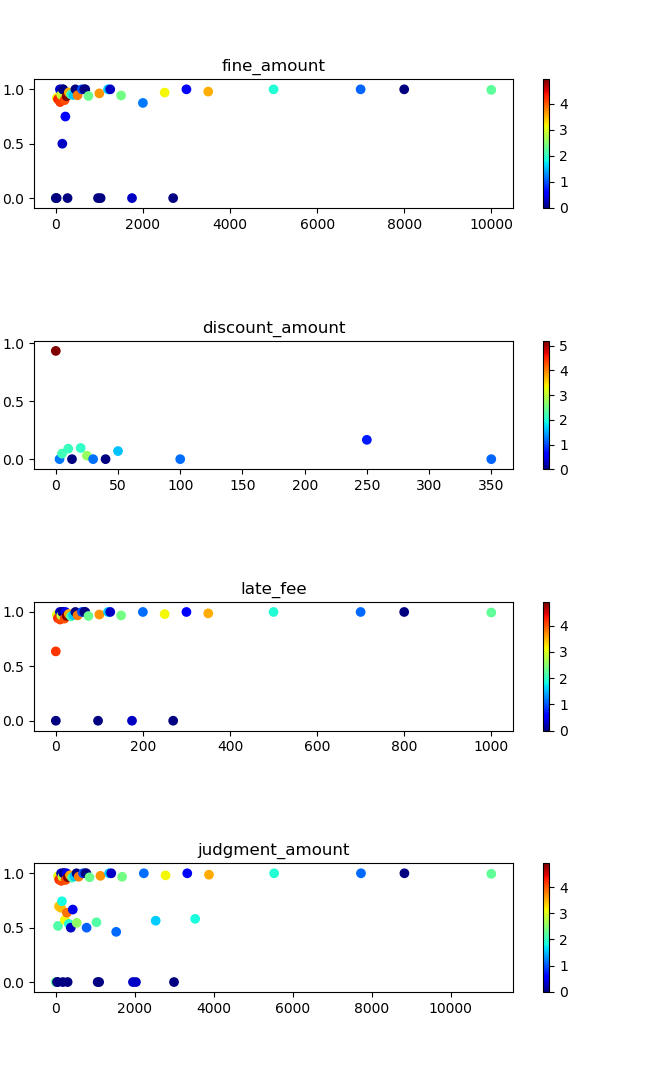

In [220]:
# scatterplots showing percentage non-compliant for different features
# only do numeric ones
colnames=['fine_amount','discount_amount','late_fee','judgment_amount']

%matplotlib notebook
import matplotlib as mpl
import matplotlib.pyplot as plt

cmap=mpl.cm.jet
fig, axes = plt.subplots(len(colnames),1)

for i, col in enumerate(colnames):
    ctTot=pd.crosstab(Xall[col], y, margins=True)
    ctNorm=pd.crosstab(Xall[col], y, normalize='index')
    ctNorm['N']=Xall[col].value_counts()
    
    ax=axes[i]
    sc=ax.scatter(ctNorm.index,ctNorm[0.0],c=np.log10(ctNorm['N']),cmap=cmap)
    ax.set_title(col)
    plt.colorbar(sc,ax=ax)
    
plt.tight_layout()

In [246]:
Xall.columns

Index(['agency_name', 'inspector_name', 'violator_name',
       'violation_street_number', 'violation_street_name',
       'violation_zip_code', 'mailing_address_str_number',
       'mailing_address_str_name', 'city', 'state', 'zip_code',
       'non_us_str_code', 'country', 'ticket_issued_date', 'hearing_date',
       'violation_code', 'violation_description', 'disposition', 'fine_amount',
       'admin_fee', 'state_fee', 'late_fee', 'discount_amount',
       'clean_up_cost', 'judgment_amount', 'payment_amount', 'balance_due',
       'payment_date', 'payment_status', 'collection_status',
       'grafitti_status', 'compliance_detail', 'TimeDiff', 'hearing_month',
       'issue_month', 'hearing_day', 'issue_day', 'hearing_dayofweek',
       'issue_dayofweek', 'address', 'lat', 'lon'],
      dtype='object')

<IPython.core.display.Javascript object>


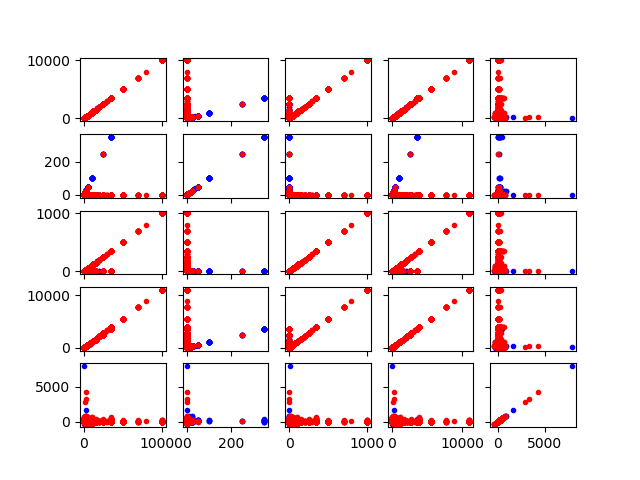

Plotting fine_amount:fine_amount in (0,0)
Plotting fine_amount:discount_amount in (0,1)
Plotting fine_amount:late_fee in (0,2)
Plotting fine_amount:judgment_amount in (0,3)
Plotting fine_amount:TimeDiff in (0,4)
Plotting discount_amount:fine_amount in (1,0)
Plotting discount_amount:discount_amount in (1,1)
Plotting discount_amount:late_fee in (1,2)
Plotting discount_amount:judgment_amount in (1,3)
Plotting discount_amount:TimeDiff in (1,4)
Plotting late_fee:fine_amount in (2,0)
Plotting late_fee:discount_amount in (2,1)
Plotting late_fee:late_fee in (2,2)
Plotting late_fee:judgment_amount in (2,3)
Plotting late_fee:TimeDiff in (2,4)
Plotting judgment_amount:fine_amount in (3,0)
Plotting judgment_amount:discount_amount in (3,1)
Plotting judgment_amount:late_fee in (3,2)
Plotting judgment_amount:judgment_amount in (3,3)
Plotting judgment_amount:TimeDiff in (3,4)
Plotting TimeDiff:fine_amount in (4,0)
Plotting TimeDiff:discount_amount in (4,1)
Plotting TimeDiff:late_fee in (4,2)
Plotting 

In [248]:
# scatterplots comparing the different numeric features
colnames=['fine_amount','discount_amount','late_fee','judgment_amount','TimeDiff']

%matplotlib notebook
import matplotlib as mpl
import matplotlib.pyplot as plt


fig, axes = plt.subplots(len(colnames),len(colnames),sharex='col',sharey='row')

# plot everything against eachother
for i, icol in enumerate(colnames):     # loop over the rows
    for j, jcol in enumerate(colnames): # loop over the columns
        ax=axes[i,j]
        print("Plotting {}:{} in ({},{})".format(icol,jcol,i,j))
        ax.plot(X1[jcol],X1[icol],'b.')
        ax.plot(X0[jcol],X0[icol],'r.')


In [227]:
X1.head()

agency_name    inspector_name  \
ticket_id                                                                     
27586      Buildings, Safety Engineering & Env Department  Williams, Darrin   
18746      Buildings, Safety Engineering & Env Department  Williams, Darrin   
18744      Buildings, Safety Engineering & Env Department  Williams, Darrin   
18657      Buildings, Safety Engineering & Env Department    Schuman, Randy   
18653      Buildings, Safety Engineering & Env Department   Gailes, Orbie J   

                      violator_name  violation_street_number  \
ticket_id                                                      
27586      Michigan, Covenant House                   4311.0   
18746                   Klenk, Dean                  14715.0   
18744                    Kuhn, Dean                  14715.0   
18657                 , APB LAUNDRY                  15439.0   
18653        Garden Court Apt.s, na                   2900.0   

          violation_street_name  violation_zip_code  \
ticket_id                                             
27586                   CENTRAL                 NaN   
18746                     KLENK                 NaN   
18744                     KLENK                 NaN   
18657                      MACK                 NaN   
18653                 JEFFERSON                 NaN   

           mailing_address_str_number mailing_address_str_name     city state  \
ticket_id                                                                       
27586                          2959.0       Martin Luther King  Detroit    MI   
18746                         14715.0                    Klenk  Detroit    MI   
18744                        141715.0                    Klenk  Detroit    MI   
18657                         15439.0                     MACK  DETROIT    MI   
18653                            29.0             E. Jefferson      Det    MI   

             ...        TimeDiff hearing_month issue_month hearing_day  \
ticket_id    ...                                                         
27586        ...      378.041667           5.0           4         6.0   
18746        ...      138.125000           2.0          10        22.0   
18744        ...      138.125000           2.0          10        22.0   
18657        ...       35.208333           2.0           1        18.0   
18653        ...       39.739583           2.0           1        23.0   

          issue_day hearing_dayofweek issue_dayofweek  \
ticket_id                                               
27586            23               4.0               4   
18746             7               1.0               3   
18744             7               1.0               3   
18657            14               4.0               4   
18653            14               2.0               4   

                              address        lat        lon  
ticket_id                                                    
27586        4311 CENTRAL, DETROIT MI  42.326937 -83.135118  
18746         14715 KLENK, DETROIT MI  42.360836 -82.930958  
18744         14715 KLENK, DETROIT MI  42.360836 -82.930958  
18657          15439 MACK, DETROIT MI  42.388282 -82.942000  
18653      2900 JEFFERSON, DETROIT MI  42.339391 -83.019373  

[5 rows x 42 columns]

In [221]:
# list(ctNorm.index)

In [192]:
ctTot=pd.crosstab(Xall[col], y, margins=True)
ctNorm=pd.crosstab(Xall[col], y, normalize='index', margins=True)
ctNorm['N']=Xall[col].value_counts()
ctNorm

compliance            0.0       1.0        N
judgment_amount                             
0.0              0.000000  1.000000    195.0
31.1             0.000000  1.000000      1.0
50.0             0.000000  1.000000      1.0
55.0             0.516129  0.483871    155.0
57.5             0.973835  0.026165   1223.0
80.0             0.696739  0.303261   2760.0
85.0             0.942622  0.057378  17655.0
130.0            0.682705  0.317295   2972.0
134.5            1.000000  0.000000      2.0
140.0            0.930409  0.069591  12516.0
155.0            0.742857  0.257143     70.0
167.5            0.969571  0.030429    723.0
180.0            0.000000  1.000000      1.0
195.0            1.000000  0.000000      1.0
206.0            1.000000  0.000000      2.0
217.0            1.000000  0.000000      1.0
230.0            0.570796  0.429204   1356.0
250.0            0.939234  0.060766  11355.0
272.0            1.000000  0.000000      3.0
280.0            0.638010  0.361990   7177.0
300.0            0.000000  1.000000      1.0
305.0            0.963841  0.036159  79621.0
330.0            0.534091  0.465909     88.0
360.0            0.982065  0.017935   3680.0
380.0            0.500000  0.500000      2.0
415.0            0.960317  0.039683    126.0
430.0            0.666667  0.333333      3.0
470.0            0.972222  0.027778     36.0
525.0            1.000000  0.000000      1.0
530.0            0.544236  0.455764    373.0
580.0            0.968831  0.031169   6545.0
690.0            1.000000  0.000000     10.0
750.5            1.000000  0.000000      1.0
774.7            1.000000  0.000000      1.0
780.0            0.500000  0.500000     12.0
855.0            0.963134  0.036866    217.0
1030.0           0.549383  0.450617    162.0
1060.0           0.000000  1.000000      1.0
1097.0           0.000000  1.000000      1.0
1130.0           0.976473  0.023527   4803.0
1350.0           1.000000  0.000000     40.0
1405.0           1.000000  0.000000      2.0
1530.0           0.461538  0.538462     13.0
1680.0           0.968127  0.031873    251.0
1955.0           0.000000  1.000000      2.0
2030.0           0.000000  1.000000      2.0
2230.0           1.000000  0.000000     14.0
2530.0           0.564103  0.435897     39.0
2780.0           0.980744  0.019256   1506.0
2994.5           0.000000  1.000000      1.0
3330.0           1.000000  0.000000      4.0
3530.0           0.581081  0.418919     74.0
3880.0           0.987054  0.012946   3785.0
5530.0           1.000000  0.000000     85.0
7730.0           1.000000  0.000000     13.0
8830.0           1.000000  0.000000      1.0
11030.0          0.994872  0.005128    195.0
All              0.927464  0.072536      NaN

In [70]:
## read test model
dftest=pd.read_csv('test.csv')
dftest=dftest.set_index('ticket_id')

In [72]:
dftest.iloc[0]

agency_name                                          Department of Public Works
inspector_name                                               Granberry, Aisha B
violator_name                                                  FLUELLEN, JOHN A
violation_street_number                                                   10041
violation_street_name                                                 ROSEBERRY
violation_zip_code                                                          NaN
mailing_address_str_number                                                  141
mailing_address_str_name                                              ROSEBERRY
city                                                                    DETROIT
state                                                                        MI
zip_code                                                                  48213
non_us_str_code                                                             NaN
country                                 

In [295]:

var='violator_name'
ctTot=pd.crosstab(X[var], y, margins=True)
ctNorm=pd.crosstab(X[var], y, normalize='index', margins=True)
#     ctNorm
# X.issue_day.value_counts()
ctNorm['N']=X[var].value_counts()
dftmp=dftest[var].value_counts().to_frame(name='Ntest')
ctNorm=ctNorm.merge(dftmp,how='left',left_index=True,right_index=True)

print(ctNorm.sort_values(by=['N'], ascending=False))

                                                   0.0       1.0      N  Ntest
violator_name                                                                 
INVESTMENT, ACORN                             1.000000  0.000000  809.0    NaN
INVESTMENT CO., ACORN                         1.000000  0.000000  425.0    2.0
BANK, WELLS FARGO                             0.980237  0.019763  328.0    6.0
MILLER, JOHN                                  0.994350  0.005650  205.0    NaN
SHIFMAN, ALLEN                                1.000000  0.000000  192.0    NaN
NEW YORK, BANK OF                             0.971831  0.028169  184.0    6.0
COMMISSION, DETROIT HOUSING                   0.983333  0.016667  178.0   19.0
STEHLIK, JERRY                                0.867089  0.132911  162.0    3.0
SNOW, GEORGE                                  1.000000  0.000000  147.0    3.0
APARTMENTS, CARLTON                           1.000000  0.000000  139.0    NaN
TREASURER, WAYNE COUNTY                       0.9523

In [307]:
dftest[dftest['violator_name'].str.contains('REX ',na=False)]

agency_name    inspector_name  \
ticket_id                                                                     
329010                         Department of Public Works  Pickett, Tracine   
334585                         Department of Public Works   Frazier, Willie   
338597                         Department of Public Works   Smith, Brittany   
339770                         Department of Public Works    Lusk, Gertrina   
343553                         Department of Public Works   Smith, Brittany   
344808                         Department of Public Works     Bomar, Isaiah   
344806                         Department of Public Works     Bomar, Isaiah   
347796                         Department of Public Works       Zizi, Josue   
347795                         Department of Public Works       Zizi, Josue   
365372     Buildings, Safety Engineering & Env Department   Shah , Kumarpal   
370181                         Department of Public Works   McClain, Melvin   
374082                         Department of Public Works  Pickett, Tracine   
375173                         Department of Public Works  Pickett, Tracine   

                      violator_name  violation_street_number  \
ticket_id                                                      
329010     REX CONSTRUCTION COMPANY                  14898.0   
334585         REX CONSTRUCTION, CO                  15779.0   
338597         REX CONSTRUCTION CO.                   9632.0   
339770         CO, REX CONSTRUCTION                  18518.0   
343553         REX CONSTRUCTION CO.                  12731.0   
344808         CO, REX CONSTRUCTION                  18382.0   
344806         CO, REX CONSTRUCTION                  18382.0   
347796             REX CONSTRUCTION                  16591.0   
347795             REX CONSTRUCTION                  16591.0   
365372         REX CONSTRUCTION CO.                  14815.0   
370181         REX CONSTRUCTION CO.                  12690.0   
374082         REX CONSTRUCTION CO.                  19720.0   
375173          REX CONSTRUCTION CO                  19300.0   

          violation_street_name violation_zip_code mailing_address_str_number  \
ticket_id                                                                       
329010              LITTLEFIELD              48227                        484   
334585                 FIELDING              48223                      14815   
338597                  DECATUR              48227                      14815   
339770                   BRAILE                NaN                      14815   
343553                    ILENE              48238                      14815   
344808               SHIAWASSEE              48219                      14815   
344806               SHIAWASSEE              48219                      14815   
347796                    COYLE              48235                      14815   
347795                    COYLE              48235                      14815   
365372              GRAND RIVER                NaN                    P O BOX   
370181                  BIRWOOD              48227                      14815   
374082                  TRINITY              48219                      14815   
375173                  TRINITY              48219                      14815   

          mailing_address_str_name        city state       ...         \
ticket_id                                                  ...          
329010                    P.O. BOX  SOUTHFIELD    MI       ...          
334585                 GRAND RIVER     DETROIT    MI       ...          
338597                 GRAND RIVER     DETROIT    MI       ...          
339770                 GRAND RIVER     DETROIT    MI       ...          
343553                 GRAND RIVER     DETROIT    MI       ...          
344808                 GRAND RIVER     DETROIT    MI       ...          
344806                 GRAND RIVER     DETROIT    MI       ...          
347796                 GRA

In [33]:
d1=df[df['mailing_address_str_number']==1].copy()
d1['city']=d1['city'].str.upper()
d1['mailing_address_str_name']=d1['mailing_address_str_name'].str.upper()
# d1.apply(lambda x: x.upper())

In [34]:
d1[d1['mailing_address_str_number']==1]

agency_name  \
ticket_id                                                   
18871      Buildings, Safety Engineering & Env Department   
19015      Buildings, Safety Engineering & Env Department   
19123                          Department of Public Works   
19127                          Department of Public Works   
19251      Buildings, Safety Engineering & Env Department   
19243      Buildings, Safety Engineering & Env Department   
19430      Buildings, Safety Engineering & Env Department   
19527      Buildings, Safety Engineering & Env Department   
19561      Buildings, Safety Engineering & Env Department   
19787                           Detroit Police Department   
19726      Buildings, Safety Engineering & Env Department   
19692      Buildings, Safety Engineering & Env Department   
19689      Buildings, Safety Engineering & Env Department   
19949      Buildings, Safety Engineering & Env Department   
19958      Buildings, Safety Engineering & Env Department   
19937      Buildings, Safety Engineering & Env Department   
20093      Buildings, Safety Engineering & Env Department   
20311                          Department of Public Works   
28857      Buildings, Safety Engineering & Env Department   
28859      Buildings, Safety Engineering & Env Department   
21187      Buildings, Safety Engineering & Env Department   
21651      Buildings, Safety Engineering & Env Department   
21807                                   Health Department   
21902                          Department of Public Works   
21907                          Department of Public Works   
22627                                   Health Department   
22475                          Department of Public Works   
22601      Buildings, Safety Engineering & Env Department   
22857      Buildings, Safety Engineering & Env Department   
23012                          Department of Public Works   
...                                                   ...   
280533                         Department of Public Works   
281456     Buildings, Safety Engineering & Env Department   
281459     Buildings, Safety Engineering & Env Department   
281457     Buildings, Safety Engineering & Env Department   
281185                         Department of Public Works   
281182                         Department of Public Works   
281458     Buildings, Safety Engineering & Env Department   
282504                         Department of Public Works   
282505                         Department of Public Works   
282662                         Department of Public Works   
282600                          Detroit Police Department   
287605                         Department of Public Works   
283034     Buildings, Safety Engineering & Env Department   
283033     Buildings, Safety Engineering & Env Department   
283039     Buildings, Safety Engineering & Env Department   
283035     Buildings, Safety Engineering & Env Department   
283529                         Department of Public Works   
283530                         Department of Public Works   
283374                          Detroit Police Department   
283522                         Department of Public Works   
283831                         Department of Public Works   
284692                         Department of Public Works   
283803                         Department of Public Works   
284438                         Department of Public Works   
284207                         Department of Public Works   
284466                         Department of Public Works   
284119                         Department of Public Works   
284439                         Department of Public Works   
284563                         Department of Public Works   
284601                         Department of Public Works   

                inspector_name                            violator_name  \
ticket_id                                                                 
18871          Brinkley, Kevin                    Co

In [284]:
# dftmp=pd.DataFrame(data=dftest[var].value_counts())
dftest[var].value_counts()

HOMES LDHA LP, MLK                                                91
WEEKS, DANA                                                       82
PROPERTIES, LLC, KAY BEE KAY                                      60
MAE, FANNIE                                                       55
FELLOWSHIP ESTATES LLC, -                                         54
DET 123 FUND LLC                                                  48
ARTESIAN EQUITIES LLC, -                                          42
& HERBERT STRATHER, FELLOWSHIP ESTATES LLC C/O WENDELL ANTHONY    39
ARTESIAN EQUITIES LLC                                             38
SUMMIT ACQUISITIONS LLC                                           35
WESTGATE TERRACE APARTMENTS LLC                                   32
TRADIN PLACES LLC                                                 31
SG COMPANIES                                                      29
GLOBAL PREMIER ASSET SERVICING                                    29
FANNIE MAE                        

In [289]:
dftmp=dftest[var].value_counts().to_frame(name='Ntest')

In [326]:
ctNorm[ctNorm.index.str.contains('ACORN',na=False)].sort_values(by=['Ntest','N'], ascending=False)

0.0  1.0      N  Ntest
violator_name                                                  
INVESTMENTS, ACORN                       1.0  0.0  122.0    7.0
INVESTMENT CO, ACORN                     1.0  0.0   87.0    6.0
ACORN INVESTMENT CO., .                  1.0  0.0   18.0    3.0
INVESTMENT CO., ACORN                    1.0  0.0  425.0    2.0
CO, ACORN INVESTMENT                     1.0  0.0   14.0    2.0
COMPANY, ACORN INVESTMENT                1.0  0.0   51.0    1.0
INVESTMENT CO. , ACORN                   1.0  0.0    4.0    1.0
INVESTMENT, ACORN                        1.0  0.0  809.0    NaN
ACORN INVESTMENT, *                      1.0  0.0   52.0    NaN
ACORN INVESTMENT COMPANY, .              1.0  0.0   49.0    NaN
CO., ACORN INVESTMENT                    1.0  0.0   32.0    NaN
INVESTMENT COMPANY, ACORN                1.0  0.0   20.0    NaN
ACORN INVESTMENTS, *                     1.0  0.0   14.0    NaN
., ACORN                                 1.0  0.0   13.0    NaN
ACORN, *                                 1.0  0.0   13.0    NaN
ACORN INVESTMENT CO., *                  1.0  0.0    6.0    NaN
COMPANY, ACORN  INVESTMENT               1.0  0.0    5.0    NaN
ACORN INVESTMENTS, .                     1.0  0.0    4.0    NaN
ACORN INVESTMENT COMPANY, . .            1.0  0.0    3.0    NaN
CO, ACORN  INVESTMENT                    1.0  0.0    3.0    NaN
CO., ACORN  INVESTMENT                   1.0  0.0    3.0    NaN
INVESMENT, ACORN                         1.0  0.0    3.0    NaN
INVESTMENT COMP., ACORN                  1.0  0.0    3.0    NaN
INVESTMENTS CO., ACORN                   1.0  0.0    3.0    NaN
ACORN INVESTMENT CO, *                   1.0  0.0    2.0    NaN
ACORN INVESTMENT CO, .                   1.0  0.0    2.0    NaN
ACORN INVESTMENT CO., . .                1.0  0.0    2.0    NaN
ACORN INVESTMENTS, ...                   1.0  0.0    2.0    NaN
ACORN INVESTMENTS, ....                  1.0  0.0    2.0    NaN
CO., ACORN INVESTMENTS                   1.0  0.0    2.0    NaN
COMP., ACORN INVESTMENT                  1.0  0.0    2.0    NaN
INC., ACORN INVESTMENT                   1.0  0.0    2.0    NaN
INVESTMENT  CO, ACORN                    1.0  0.0    2.0    NaN
IVESTMENT, ACORN                         1.0  0.0    2.0    NaN
00000000000000000, ACORN INVESTMENT CO.  1.0  0.0    1.0    NaN
ACORN  INVESTMENTS  CO., .               1.0  0.0    1.0    NaN
ACORN INVESMENTS, *                      1.0  0.0    1.0    NaN
ACORN INVESMENTS, ....                   1.0  0.0    1.0    NaN
ACORN INVESTMENT CO, 000000000           1.0  0.0    1.0    NaN
ACORN INVESTMENT, 000000000000           1.0  0.0    1.0    NaN
ACORN INVESTMENT, CO                     1.0  0.0    1.0    NaN
ACORN INVESTMENTS CO, .                  1.0  0.0    1.0    NaN
ACORN INVESTMENTS COMPANY, .             1.0  0.0    1.0    NaN
ACORN INVSTM. CO., .                     1.0  0.0    1.0    NaN
CO, ACORN INVESTMENTS                    1.0  0.0    1.0    NaN
COMP, ACORN INVERTMENT                   1.0  0.0    1.0    NaN
COMPANY, ACORN   INVESTMENT              1.0  0.0    1.0    NaN
COMPANY, ACORN INVESTMENE                1.0  0.0    1.0    NaN
COMPANY, ACORN INVESTMENTS               1.0  0.0    1.0    NaN
COMPLANY, ACORN INVESTMENT               1.0  0.0    1.0    NaN
INNESTMENT, ACORN                        1.0  0.0    1.0    NaN
INVESTEMENT, ACORN                       1.0  0.0    1.0    NaN
INVESTEMNT, ACORN                        1.0  0.0    1.0    NaN
INVESTENT CO., ACORN                     1.0  0.0    1.0    NaN
INVESTMENT   CO, ACORN                   1.0  0.0    1.0    NaN
INVESTMENT CO,., ACORN                   1.0  0.0    1.0    NaN
INVETMENT CO., ACORN                     1.0  0.0    1.0    NaN
c/o ACORN INV., OAK MANAGEMENT           1.0  0.0    1.0    NaN

In [294]:
dftmp.index

Index(['HOMES LDHA LP, MLK', 'WEEKS, DANA', 'PROPERTIES, LLC, KAY BEE KAY',
       'MAE, FANNIE', 'FELLOWSHIP ESTATES LLC, -', 'DET 123 FUND LLC',
       'ARTESIAN EQUITIES LLC, -',
       '& HERBERT STRATHER, FELLOWSHIP ESTATES LLC C/O WENDELL ANTHONY',
       'ARTESIAN EQUITIES LLC', 'SUMMIT ACQUISITIONS LLC',
       ...
       'Y&I ASSOCIATES, Y&I', 'RBC CAPITAL HOLDING LLC',
       'SINGH HOUSING & INVESTMENTS LL, .', 'GIBSON, DIQUITA',
       'DEE DOMINGO, AVARSHA LLC', 'INTERESTATE INVESTGROUP LLC, -',
       'Bridge Resource Solutions', 'RC SQUARD, LLC, ...',
       'RENAUD, DAVID & MARY', 'EXPRESS AUTO REPAIR/SAAD NAMO, .'],
      dtype='object', length=38515)